<a href="https://colab.research.google.com/github/ElisonSherton/Collaborative-Filtering-On-Anime-Dataset/blob/master/AnimeRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an Anime Recommendation System using fastai

The dataset for this experiment is available on [kaggle here](https://www.kaggle.com/CooperUnion/anime-recommendations-database?select=anime.csv).

## Introduction
In today's world where data is oil, one way of utiliziing data is to perform the task of suggestion/recommendation for individuals. In this fast paced world where content is created at an astounding pace, viewers like it when they're suggested content similar to what they've seen before. 

In order to do so, the choices, likes, tastes of the users are recorded in the form of ratings or a score which is typically bound in a finite range (most commonly 0-5 or 0-10) where 0 represents that the user strongly disliked the content and 5 or 10 represent that the user found the content very entertaining and to his liking. 

Using this data in order to figure out what to next to suggest to a user is what collaborative filtering is all about. In place of user-anime or user-movie it could be anything like consumer-product or user-news article or subscriber-social media posts and so on. 

The more feedback that is obtained from the user, the more relevent the suggestions become because the algorithm gets to understand the tastes of an individual more and more.

There are several ways to perform collaborative filtering and today, we'll be discussing two of them. We'll be using fastai2 which is a library built by Sylvain Gugger and Jeremy Howard which is an awesome interface built on top of PyTorch for performing deep learning experiments. So, without any further ado, let's get started.

## The basis
In order to perform collaborative filtering, both the user/ subscriber/ consumer and the item/ article/ product are represented as matrices. (terminology here is specific to the application but since we're dealing with anime data, we'll call users as viewers and item as anime respectively.)

More precisely, every user is represented as a vector of numeric values and so is every anime. These values are learned by the algorithm to minimize a loss function which is most commonly the Mean Squared Error Loss (MSE). 

The values learned for the user and anime vectors correspond to an abstract n-dimensional space and really have no human-interpretable meaning. But as an attempt to understand what's really happening, we can think of it this way.

Let's say every anime consists of 5 components - romance, comedy, slice of life, harem and action. Then an anime can be represented in the vector space of 5-Dimensions each dimension being one of the above. 

In that 5-Dimensional world, Oregairu and Hyouka would be closer to each other and Tokyo Ghoul would be relatively far from them. This approach therefore creates a n-dimensional space where all anime that have similar components will be grouped closer than the ones which have different anime.

Now, think of the viewer. The viewer vector will on the other hand represent what proportion of every dimension is dear to the user. Let's say the user is a fan of romance and slice of life, then the vector representation of this user will have high numeric values along those dimensions and a smaller numeric value along the remaining dimensions. 

In order to consolidate the information from both the viewer and anime we resort to using the dot product which is a simple multiplication along the respective vector dimensions followed by an aggregation. Let me explain this using the scenario we considered above. 

As we can see Hyouka and Oregairu have mostly similar values along all the dimensions and Tokyo Ghoul has pretty different values across all dimensions. Viewer 1 prefers action and slice of life a lot more than other components, so, let's compute the dot product of viewer 1 with all three anime.

Viewer 1's dot product with all three anime are 29.2, 26 and 31.8 respectively. This means Viewer 1 likes Tokyo Ghoul the best which is indeed high on action. 

Viewer 2 on the other hand is into romance and harem. His dot product with all three anime are 47.5, 35.5, 22.5 which means he would like Oregairu the most which is indeed a teenage love comedy! Yukinoshita, Yuigahama, Ishhiki damn even Shizuka, his teacher, seem to have the hots for Hachiman; don't you dare tell me you overlooked the harem in this anime...

After that otaku tangent, getting back to the topic at hand, we can see how representing viewers and anime as a vector can prove useful to determine a ranking of how a viewer would like all the anime or which users will like a particular anime and that's a very valuable insight which streaming companies like Netflix are exploiting. 

There's also an additional component to both the viewer and the anime which is technically called bias. It is a quantity used to represent unique information about that particular user or that particular anime respectively. So, if there's a user who on an average rates all anime highly or there's an anime which is a favorite across all viewers irrespective of their choices, such information is captured by a term called bias. So, every viewer and every anime is represented in this structure using an n-dimensional vector and a bias term. 

## Collaborative Filtering in fastai2
fastai2 provides a learner called collab_learner which could be used in order to perform collaborative filtering. Let's dive right into it.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import matplotlib.style as style
style.use('fivethirtyeight')

In [ ]:
!pip install -Uqq fastbook
import fastbook

In [ ]:
from fastbook import *

In [ ]:
from fastai import *
from fastai.collab import *

In [ ]:
os.chdir("./drive/My Drive/Colab Notebooks/AnimeRecommendations")

In [ ]:
os.listdir(".")

['anime.csv',
 'rating.csv',
 'models',
 'Embedding_Dot_Bias_Recommender_model.pkl',
 'final_data.csv',
 'train_ds_xs.csv',
 'valid_ds_xs.csv',
 'train_ds_ys.csv',
 'valid_ds_ys.csv']

In [ ]:
final_data = pd.read_csv("./final_data.csv")
train_ds_xs = pd.read_csv("./train_ds_xs.csv")

In [ ]:
data = pd.read_csv("./rating.csv", na_values=[-1])
data.columns = ['user_id', 'anime_id', 'ratings']
data.head()

,user_id,anime_id,ratings
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


In [ ]:
print(f"Total entries in data: {len(data)}")

Total entries in data: 7813737


In [ ]:
anime_data = pd.read_csv("./anime.csv")
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.16,151266


There are people who have seen anime but not rated it. Such users are represented with a -1 in the ratings column. Hence read all the -1 ratings values as na_values.

Our model will not work with NaN values, so we will have to impute that column with the mean rating for the respective anime_id. Firstly, we'll have to check if all the anime in ratings data actually exist in anime data and if not, only keep the ratings for those anime present in anime_data.

In [ ]:
different = set(data.anime_id).difference(anime_data.anime_id)
different

{20261, 30913, 30924}

In [ ]:
ids = data[data.anime_id.apply(lambda x: x in different)].index
data = data.drop(ids).reset_index()
print(f"Total entries in data: {len(data)}")

Total entries in data: 7813727


Also, we can see that the amount of anime involved is a lot. We will not be able to deal with such a large corpus of data and will narrow it down to include top 5000 anime which have the most number of members.

**Why top 5k by members and not top 5k by average rating?**

Well, in this dataset, there are anime which are only rated by 5-10 people very highly or very lowly. They do not represent the true sentiment of the larger viewer community. If we were to think of the average rating as a pragmatic estimate, we want the anime to have been watched and rated by as many members as possible. Hence this step.

In [ ]:
not_permitted_anime_ids = list(anime_data.sort_values(by = ['members'], ascending = False)[5000:].anime_id)

ids = data[data.anime_id.apply(lambda x: x in not_permitted_anime_ids)].index
data = data.drop(ids).reset_index()
print(f"Total entries in data: {len(data)}")

Total entries in data: 7677496


It can be seen that we have reduced number of recommendations down from 7.8M to 7.6M by keeping only 5k anime_ids

This means our model will have almost 7k less embeddings but still get to learn on nearly 7M ratings which is a great thing!

In [ ]:
anime_rating_mapping = {int(k):v for k,v in anime_data[['anime_id', 'rating']].values}

imputed_ratings = []
for anime_id, item in data[["anime_id", "ratings"]].values:
    if np.isnan(item):
        imputed_ratings.append(anime_rating_mapping[int(anime_id)])
    else:
        imputed_ratings.append(item)

In [ ]:
data["ratings"] = imputed_ratings

In [ ]:
final_data = pd.merge(left = data, right = anime_data, how = "inner", on = "anime_id")
final_data = final_data.dropna()  # Some anime have missing genre or members data, so drop those records as well.
final_data.head()

,level_0,index,user_id,anime_id,ratings,name,genre,type,episodes,rating,members
0,0,0,1,20,7.81,Naruto,"Action, Comedy, Martial Arts, Shounen, Super Power",TV,220,7.81,683297
1,156,156,3,20,8.00,Naruto,"Action, Comedy, Martial Arts, Shounen, Super Power",TV,220,7.81,683297
2,306,306,5,20,6.00,Naruto,"Action, Comedy, Martial Arts, Shounen, Super Power",TV,220,7.81,683297
3,769,769,6,20,7.81,Naruto,"Action, Comedy, Martial Arts, Shounen, Super Power",TV,220,7.81,683297
4,1162,1162,10,20,7.81,Naruto,"Action, Comedy, Martial Arts, Shounen, Super Power",TV,220,7.81,683297


In [ ]:
# final_data.to_csv("./final_data.csv", index=False)

Generally, data is represented in this way. Although this is not a very intuitive way to look at it, it's a pretty efficient way to store data. This is because most viewers haven't seen most anime. 

When such is the case, there will be a lot of zeros if we try to store it as a matrix of viewers v/s anime. Such matrices are called sparse matrices. There are efficient ways to store such matrices as well, however we would let it pass for the time being. Let's focus on the task at hand now.

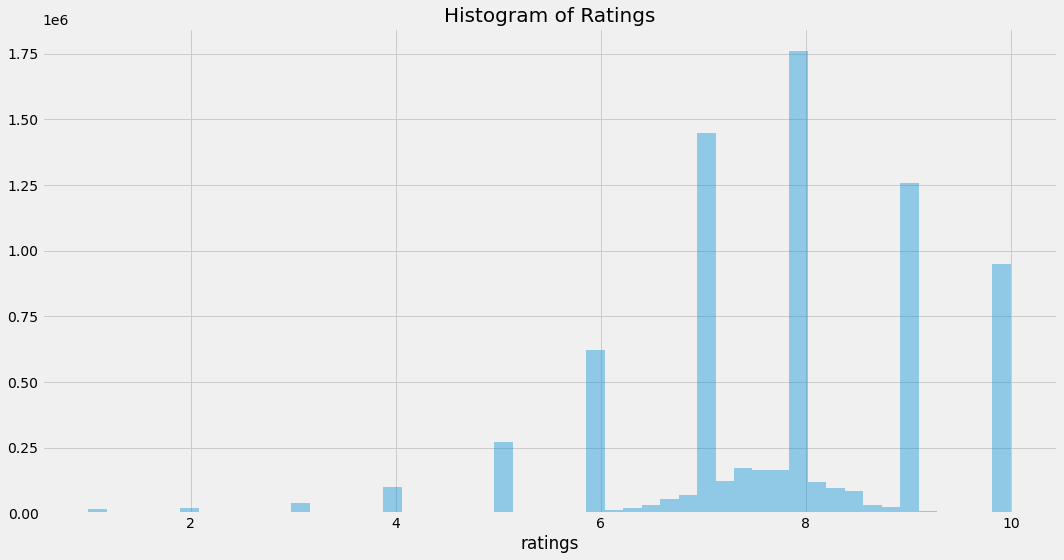

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.distplot(data.ratings, ax = ax, kde = False)
ax.set_title("Histogram of Ratings", fontsize = 20)
plt.tight_layout();

We can observe that there are relatively few users who have rated on middle grounds. Many viewers liked many anime more frequently and there's a small frequency of users who strongly disliked any anime.

We need to load the data in a specific format for feeding it to the neural network. The collab subpackage of fastai contains a module called `CollabDataLoaders` which we can use in order to load the data.

Particularly since we're loading the data from a pandas dataframe, we'll be using the from_df factory method to load the data.

In [ ]:
dloader = CollabDataLoaders.from_df(final_data, user_name = "user_id", item_name = "name", rating_name = "ratings", bs=64, seed = 0)
dloader.show_batch()

,user_id,name,ratings
0,37410,Hataraku Maou-sama!,7.00
1,45372,Noragami,8.17
2,12314,91 Days,10.00
3,26931,Shingeki no Kyojin: Ano Hi Kara,5.00
4,2817,Karneval (TV),8.00
5,6599,Kodomo no Jikan: Ni Gakki,7.32
6,28250,Bishoujo Senshi Sailor Moon: Sailor Stars,10.00
7,32436,Dragon Ball Z Movie 12: Fukkatsu no Fusion!! Gokuu to Vegeta,8.00
8,37347,Ore no Imouto ga Konnani Kawaii Wake ga Nai.,9.00
9,11141,Futakoi Alternative,8.00


So we create a DataLoader above. Since the names of columns could be application specific, we need to specify the names of user, item and ratings columns respectively. 

The argument valid_pct stands for validation data percentage. Once we build a model, it's actual sanctity is gauged by how well it performs on this data. Our model will be trained using 90% of the available data and tested on this 10% of validation data which it has never seen before. Only when our model performs well on both the training and validation sets, can we say that we've done a decent job.

With this `dloader` object, we can see what all it contains.

In [ ]:
print(dloader.classes)
print(f"Number of viewers: {len(dloader.classes['user_id'])}")
print(f"Number of anime: {len(dloader.classes['name'])}")

{'user_id': (#72963) ['#na#',1,2,3,4,5,6,7,8,9...], 'name': (#4802) ['#na#','&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi','&quot;Bungaku Shoujo&quot; Memoire','&quot;Bungaku Shoujo&quot; Movie','.hack//G.U. Returner','.hack//G.U. Trilogy','.hack//G.U. Trilogy: Parody Mode','.hack//Gift','.hack//Intermezzo','.hack//Liminality'...]}
Number of viewers: 72963
Number of anime: 4802


In [ ]:
# Store the order of classes in both user_id and name for the sake of retrieval later on
order = {k:list(v) for k,v in dloader.classes.items()}
with open("dataloader_order.pkl", "wb") as f:
    pickle.dump(order, f)
    f.close()

# Store the postions of the users in train dataset and validation dataset for easy retrieval later on
obj = {"Train_viewers": dloader.train_ds.xs.user_id.unique(),
       "Train_anime":dloader.train_ds.xs.name.unique(),
       "Valid_viewers":dloader.valid_ds.xs.user_id.unique(),
       "Valid_anime":dloader.valid_ds.xs.name.unique()}

with open("dataloader_train_valid_split.pkl", "wb") as f:
    pickle.dump(obj, f)
    f.close()

Now that we have processed the data and have it ready for building our model, let's get to actually building the model.


## Embedding Dot Bias Model

This model is a plain model just like we discussed in `The basis` section above. Both viewers and anime are represented as vectors and we get matrices for the same since there's many viewers and many anime. Next, we do the dot product on them and compare them with our actual viewer ratings using the loss function Mean Squared Error which we aim to reduce. Eventually the model will become good at representing both the viewers and anime in this n-dimensional space. 

Let's create a simple model and train it and evaluate it's performance.

In [ ]:
# This is an empirical trick which is meant to make the embedding better
# We basically constrain the output of dot product between a slightly 
# expanded range in order to improve the quality of embeddings
min_rating = final_data.ratings.min()
max_rating = final_data.ratings.max() + 0.5

# Representing every user and every movie as a vector of length 50
learn = collab_learner(dls = dloader, n_factors = 50, y_range = (min_rating, max_rating))

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=0.3019951581954956)

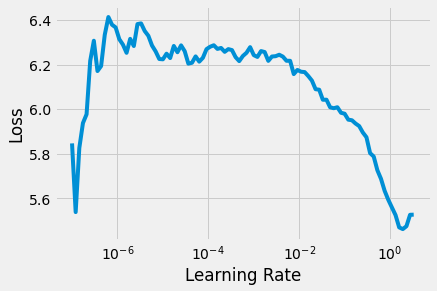

In [ ]:
# Find a proper learning rate
learn.lr_find()

In [ ]:
# Run the learner for 5 episodes with a small weight decay for regularization
learn.fit_one_cycle(n_epoch = 6, lr_max = 5e-3, wd = 1e-3)

epoch,train_loss,valid_loss,time
0,1.279564,1.364598,19:26
1,1.591914,1.587528,19:21
2,1.430645,1.429105,19:02
3,1.191953,1.224636,19:20
4,0.994112,1.111616,19:12
5,0.777396,1.114774,19:03


In [ ]:
# Save the model for inference later on
learn.export("./Embedding_Dot_Bias_Recommender_model.pkl")

In [ ]:
learn = load_learner("./Embedding_Dot_Bias_Recommender_model.pkl", cpu = False)

# The Neural Network Model

On top of embedding dot-bias model we can build an MLP by adding fully connected layers for enhancing the complexity of models. Basically the user and movie vectors are concatenated and passed through a series of neural networks before taking the final dot product. Although in most of the cases, the former performs reasonably well, this neural network model also does work well in some other cases.

It's a matter of performing trials and looking at the best performing network on evaluation of validation data that we can come to a conclusion on which model performs better. Let's build a model using Neural Networks as well and test the performance on that.

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=0.010964781977236271)

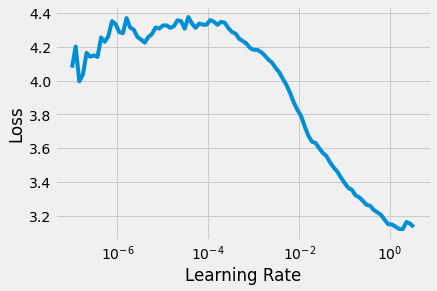

In [ ]:
# Representing every user and every movie as a vector of length 60
# Add two layers in the network each with 120 neurons and 50 neurons respectively
learn_nn = collab_learner(dls = dloader, use_nn = True, emb_szs = {"user_id":50, "name":50}, y_range = (min_rating, max_rating), layers = [50, 10])

# Find an appropriate learning rate
learn_nn.lr_find()

In [ ]:
# Run the learner for 5 episodes with a small weight decay for regularization
learn_nn.fit_one_cycle(n_epoch = 5, lr_max = 5e-3, wd = 1e-3)

epoch,train_loss,valid_loss,time
0,1.275790,1.254378,23:37
1,1.171738,1.189533,23:58
2,1.168509,1.158959,22:59
3,1.092983,1.133920,22:51
4,1.055323,1.130566,23:12


In [ ]:
# Save the model for inference later on
learn_nn.export("./NN_Recommender_model.pkl")

In [ ]:
learn_nn = load_learner("./NN_Recommender_model.pkl", cpu = False)

# The Most Awaited Part - Interpretation & Recommendation

Now that we have a model ready, let's try to interpret it, use it and make some suggestions/recommendations.

## Understanding Anime biases and weights/embeddings

Let's try to understand the anime embeddings for the Embedding dot-bias model. First, let's see what all layers are there in the model.

In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(72963, 50)
  (i_weight): Embedding(4802, 50)
  (u_bias): Embedding(72963, 1)
  (i_bias): Embedding(4802, 1)
)

As seen, there are two components for viewers and two for anime respectively, one being the vector and another one being the bias term.

Let's order the anime which by the most rated ones being the top ones (not rated highly but the most rated i.e. the viewers watched and rated the anime).

In [ ]:
g = final_data.groupby(by = ['name'])['rating'].count()
most_rated_anime = g.sort_values(ascending=False).index.values
most_rated_anime[:10]

array(['Death Note', 'Sword Art Online', 'Shingeki no Kyojin', 'Code Geass: Hangyaku no Lelouch', 'Elfen Lied', 'Angel Beats!', 'Naruto', 'Fullmetal Alchemist', 'Fullmetal Alchemist: Brotherhood',
       'Toradora!'], dtype=object)

In [ ]:
f = lambda x: x in most_rated_anime
rtings = anime_data[anime_data.name.apply(lambda x: f(x))][["name", "rating"]].values
rtings_dict = {x[0]:x[1] for x in rtings}
anime_ratings = [rtings_dict[x] for x in most_rated_anime]

Let's check the biases for these anime and compare them against the ratings for these anime. Similarly, let's check the biases for the worst anime and compare them against the ratings for the same.


Now, let's compare the top 10 out of these and see the results.

In [ ]:
biases = learn.model.bias(arr = most_rated_anime, is_item = True)

In [ ]:
bias_rating_data = pd.DataFrame({"Name": most_rated_anime, "Ratings": anime_ratings, "Biases": biases})
bias_rating_data.sort_values(by = ["Ratings"], ascending = False).head()

,Name,Ratings,Biases
956,Kimi no Na wa.,9.37,2.053326
8,Fullmetal Alchemist: Brotherhood,9.26,1.965841
1379,Gintama°,9.25,2.061260
19,Steins;Gate,9.17,1.890625
563,Gintama&#039;,9.16,1.913329


In [ ]:
bias_rating_data.sort_values(by = ["Ratings"], ascending = True).head()

,Name,Ratings,Biases
3385,Tenkuu Danzai Skelter+Heaven,2.00,-2.079890
4488,Utsu Musume Sayuri,2.14,-1.893989
1581,Hametsu no Mars,2.37,-1.819410
3426,Shitcom,2.93,-1.371397
3863,Vampire Holmes,3.63,-0.751566


Looking at this it is evident that biases capture the ratings relations quite well. Now let's turn our attention to weights of the models.

As we discussed, the weights are nothing but vectors learned by the models. Let's find out the weights of top 100 anime, apply a PCA on them to reduce their dimensionality and then compare them visually on a 2-Dimensional plot. PCA is a dimensionality reduction technique used to compress vector/matrices and is commonly applied particularly when we have to visualize large dimensional data or if we face the Curse of Dimensionality problem in datasets with numerous features or columns. 

In [ ]:
most_rated_anime_weights = learn.model.weight(most_rated_anime, is_item = True)
most_rated_anime_weights_compressed = most_rated_anime_weights.pca(2).T

In [ ]:
most_rated_anime_weights_compressed.shape

torch.Size([2, 4801])

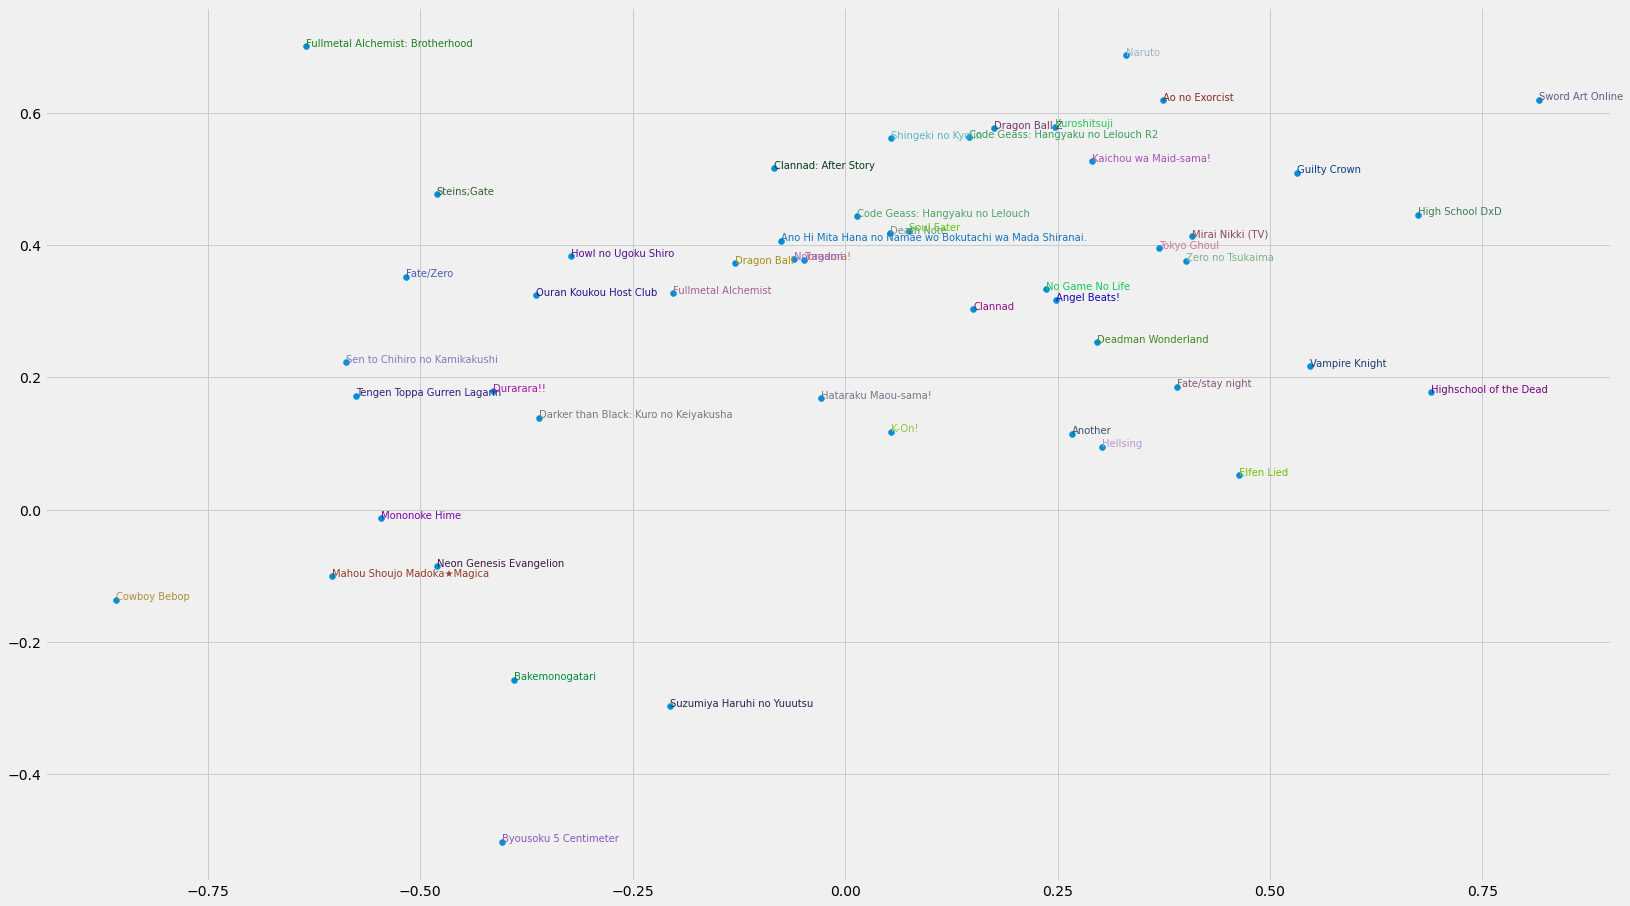

In [ ]:
plot_n = 50
idxs = list(range(plot_n))

X = most_rated_anime_weights_compressed[0,:plot_n]
Y = most_rated_anime_weights_compressed[1,:plot_n]

plt.figure(figsize=(25,15))
plt.scatter(X, Y)
for i, x, y in zip(most_rated_anime[idxs], X, Y):
    plt.text(x, y, i, color = np.random.rand(3) * 0.8, fontsize=10)
# plt.ylim(-0.0005,0.0005)
plt.show()

Now let's test the hypothesis about Oregairu, Hyouka and Tokyo Ghoul

In [ ]:
TG = learn.model.weight(["Tokyo Ghoul"], is_item = True)
Oregairu = learn.model.weight(["Yahari Ore no Seishun Love Comedy wa Machigatteiru."], is_item = True)
Hyouka = learn.model.weight(["Hyouka"], is_item = True)

In [ ]:
TG_Oregairu = np.dot(TG.numpy(), Oregairu.numpy().T)[0][0]
print(f"Similarity between Tokyo Ghoul and Oregairu: {np.round(TG_Oregairu, 2)}")

Similarity between Tokyo Ghoul and Oregairu: -0.07999999821186066


In [ ]:
Oregairu_Hyouka = np.dot(Oregairu.numpy(), Hyouka.numpy().T)[0][0]
print(f"Similarity between Hyouka and Oregairu: {np.round(Oregairu_Hyouka, 2)}")

Similarity between Hyouka and Oregairu: 0.4399999976158142


In [ ]:
TG_Hyouka = np.dot(TG.numpy(), Hyouka.numpy().T)[0][0]
print(f"Similarity between Hyouka and Tokyo Ghoul: {np.round(TG_Hyouka, 2)}")

Similarity between Hyouka and Tokyo Ghoul: 0.019999999552965164


## Viewer analysis

Let's sample a user at random from the embedding and see it's most closest and most farthest neighbour in terms of vector embeddings from amongst the first 200 items.

In [ ]:
all_users = [dloader.classes["user_id"][x] for x in obj["Train_viewers"]]

In [ ]:
random.seed(45)
random_user = random.choice(all_users)
random_user

34908

In [ ]:
random_user_weight = learn.model.weight([random_user], is_item = False).cpu().numpy()

In [ ]:
for item in learn.model.u_weight.named_parameters():
    print(item[1].shape)

torch.Size([72963, 50])


In [ ]:
user_weights = learn.model.weight(all_users, is_item = False).cpu().numpy()

In [ ]:
user_distances = {}
for u, w in zip(all_users, user_weights):
    user_distances[u] = np.dot(random_user_weight, w.T)

In [ ]:
ranked_users = sorted(user_distances, key = lambda x: user_distances[x], reverse = True)
most_similar_user = ranked_users[0]
most_different_user = ranked_users[-1]

In [ ]:
most_similar_user_weights = learn.model.weight([most_similar_user], is_item = False).cpu().numpy()
most_diff_user_weights = learn.model.weight([most_different_user], is_item = False).cpu().numpy()

In [ ]:
most_rated_anime_weights = most_rated_anime_weights.cpu().numpy()

In [ ]:
# Find the ranking of anime for the randomly sampled user
random_user_anime_order = most_rated_anime_weights.dot(random_user_weight.T).reshape(most_rated_anime_weights.shape[0],).argsort()
random_user_anime_named_order = [most_rated_anime[x] for x in random_user_anime_order]
top_5 = random_user_anime_named_order[-5:]
top_5

['Akira',
 'Ghost in the Shell 2.0',
 'Sen to Chihiro no Kamikakushi',
 'Nakedyouth',
 'Mononoke Hime']

In [ ]:
# Find the ranking of anime for the most similar user
most_similar_user_anime_order = most_rated_anime_weights.dot(most_similar_user_weights.T).reshape(most_rated_anime_weights.shape[0],).argsort()
most_similar_user_anime_named_order = [most_rated_anime[x] for x in most_similar_user_anime_order]
top_5 = most_similar_user_anime_named_order[-5:]
top_5

['Akira',
 'Ghost in the Shell 2.0',
 'Sen to Chihiro no Kamikakushi',
 'Nakedyouth',
 'Mononoke Hime']

In [ ]:
# Find the ranking of anume for the most different user
most_diff_user_anime_order = most_rated_anime_weights.dot(most_diff_user_weights.T).reshape(most_rated_anime_weights.shape[0],).argsort()
most_diff_user_anime_named_order = [most_rated_anime[x] for x in most_diff_user_anime_order]
top_5 = most_diff_user_anime_named_order[-5:]
top_5

['Girls und Panzer der Film',
 'Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari',
 'Monogatari Series: Second Season',
 'Metal Fight Beyblade 4D',
 'Yojouhan Shinwa Taikei']